In [1]:
import os
import pickle

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from model import FiringRateModel, PolynomialActivation, train_model
from data import load_data, preprocess_data

In [2]:
#device = torch.device("mps")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def test_model(model, criterion, Is, fs, k: int):
    with torch.no_grad():
        f = fs[0] # initialize firing rate to t=0
        loss = 0
        n = 0
        for i in range(k+1, len(Is)):
            currs = Is[i-k:i+1]
            f = model(currs, f)
            loss += criterion(f, fs[i]).item()
            n += 1
    return loss / n

def predict(model, Is, fs, k: int):
    with torch.no_grad():
        f = fs[0] # initialize firing rate to t=0
        pred_fs = []
        for i in range(k+1, len(Is)):
            currs = Is[i-k:i+1]
            f = model(currs, f)
            pred_fs.append(f)
    return pred_fs

def plot_predictions(model, Is, fs, k: int):
    pred_fs = predict(model, Is, fs, k)
    ts = list(range(1, len(fs)))
    plt.plot(ts, fs[1:], label="Actual")
    plt.plot(ts, pred_fs, label="Predicted")
    plt.legend()
    plt.ylabel("Firing rate")
    plt.xlabel("t")

In [4]:
data = load_data()
data.keys()

dict_keys([583836069, 565871768, 605889373])

In [5]:
def get_train_test_data(data, cell_id, bin_size):
    Is_tr, fs_tr, Is_te, fs_te = tuple([] for _ in range(4))
    
    for sweep in data[cell_id][:-1]:
        stim_name = sweep["stimulus_name"]
        Is = torch.tensor(sweep["current"][bin_size], device=device)
        fs = torch.tensor(sweep["firing_rate"][bin_size], device=device)
        if stim_name == "Noise 2":
            Is_te.append(Is)
            fs_te.append(fs)
        elif stim_name != "Test":
            Is_tr.append(Is)
            fs_tr.append(fs)
    return Is_tr, fs_tr, Is_te, fs_te

def data_lens(Is):
    lens = [len(a) for a in Is]
    counts = {}
    for l in lens:
        if l not in counts:
            counts[l] = 0
        counts[l] += 1
    print(counts)

In [13]:
bin_size = 100
cell_id = 605889373
k = 3
loss_fn = "huber"
Is_tr, fs_tr, Is_te, fs_te = get_train_test_data(data, cell_id, bin_size)
data_lens(Is_tr)
data_lens(Is_te)

{10: 17, 70: 25, 89: 1, 50: 12, 90: 1, 260: 3, 87: 1, 74: 10}
{260: 3}


In [15]:
actv = PolynomialActivation()
actv.init_from_file(f"model/activation/{loss_fn}/bin_size_{bin_size}/{cell_id}_1e-05.pickle")
for name, p in actv.named_parameters():
    p.requires_grad = False

model = FiringRateModel(actv, k=k).to(device)
#criterion = torch.nn.HuberLoss()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

train_model(
    model, 
    criterion, 
    optimizer,
    Is_tr,
    fs_tr,
    k,
    epochs = 10,
    print_every = 1
)
'''
train_loss = test_model(
    model, 
    criterion, 
    Is_tr,
    fs_tr,
    k
)

test_loss = test_model(
    model, 
    criterion, 
    Is_te,
    fs_te,
    k
)

print(f"\nTrain Loss: {train_loss}")
print(f"Test Loss: {test_loss}")''';

Epoch 1 / Loss: 0.1253056366558667
Epoch 2 / Loss: 0.12529212192748673
Epoch 3 / Loss: 0.12529212192748673
Epoch 4 / Loss: 0.12529212192748673
Epoch 5 / Loss: 0.12529212192748673
Epoch 6 / Loss: 0.12529212192748673
Epoch 7 / Loss: 0.12529212192748673
Epoch 8 / Loss: 0.12529212192748673
Epoch 9 / Loss: 0.12529212192748673
Epoch 10 / Loss: 0.12529212192748673


'\ntrain_loss = test_model(\n    model, \n    criterion, \n    Is_tr,\n    fs_tr,\n    k\n)\n\ntest_loss = test_model(\n    model, \n    criterion, \n    Is_te,\n    fs_te,\n    k\n)\n\nprint(f"\nTrain Loss: {train_loss}")\nprint(f"Test Loss: {test_loss}")'

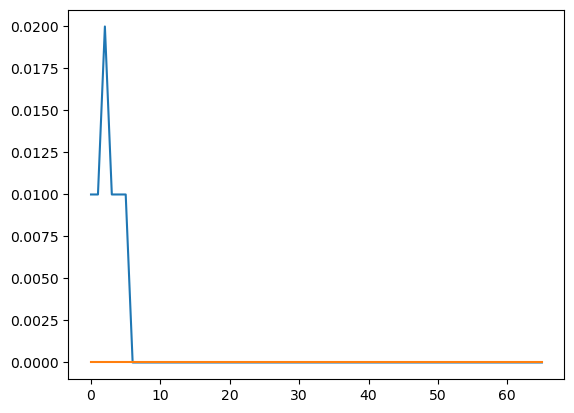

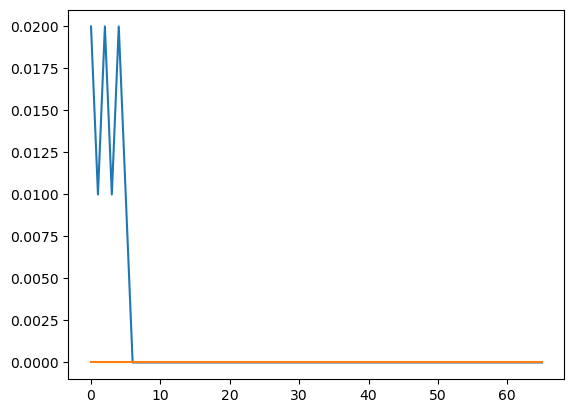

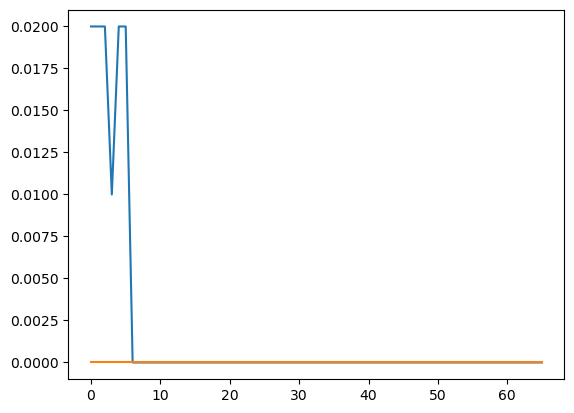

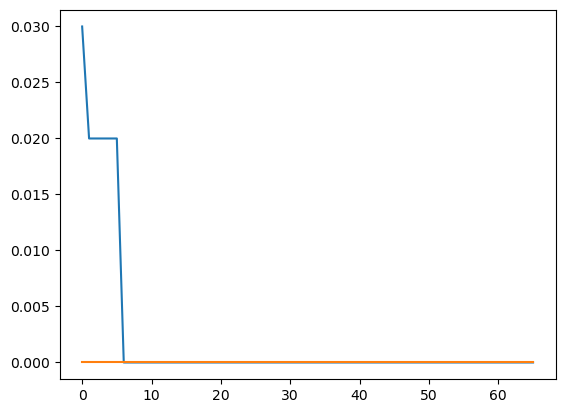

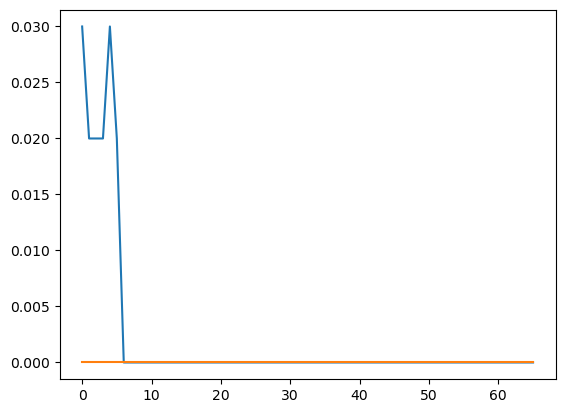

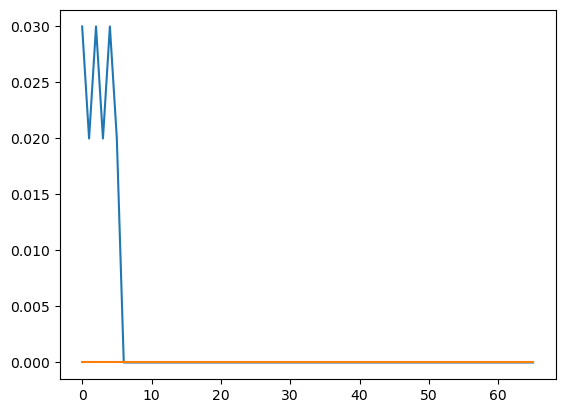

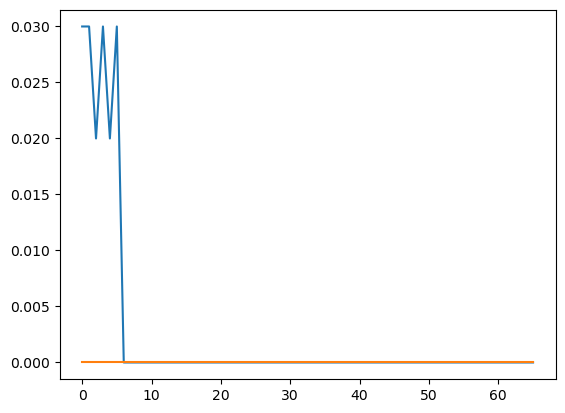

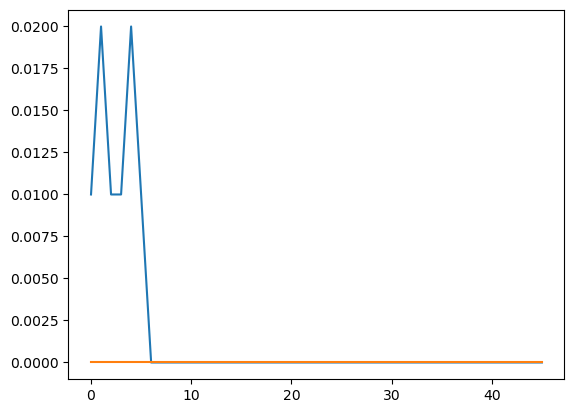

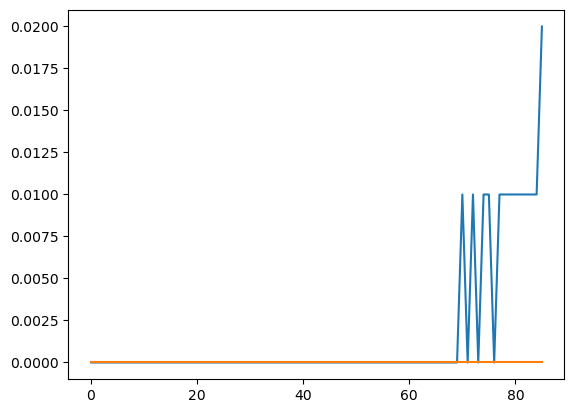

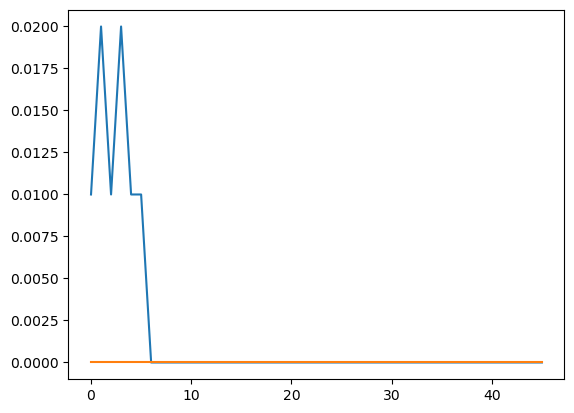

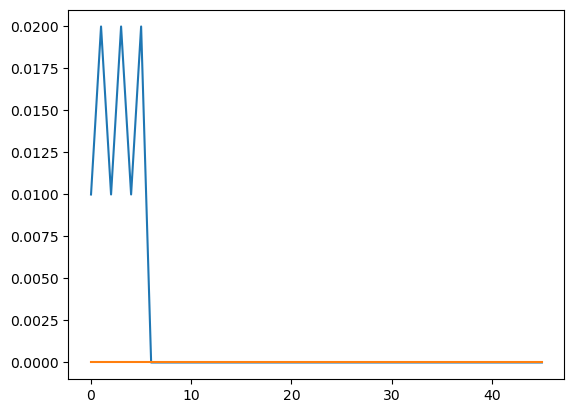

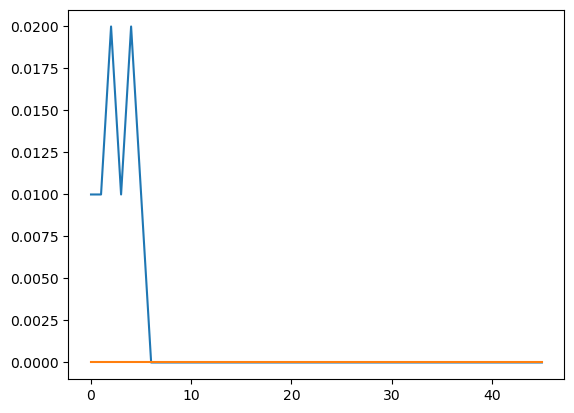

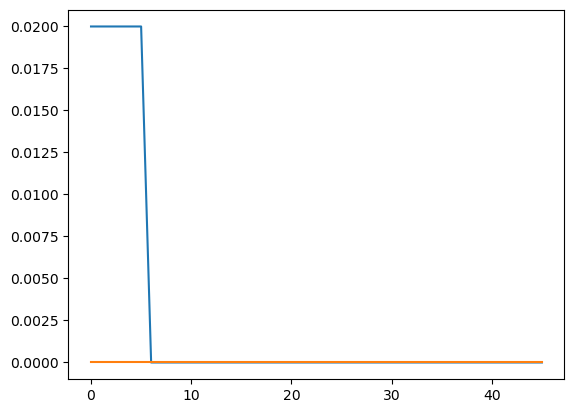

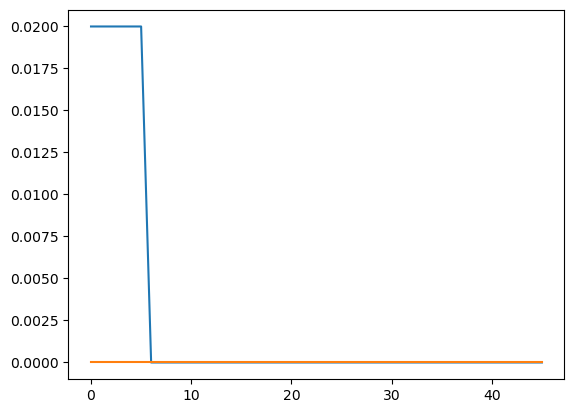

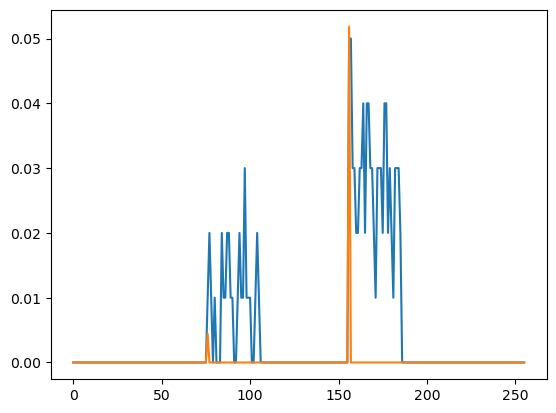

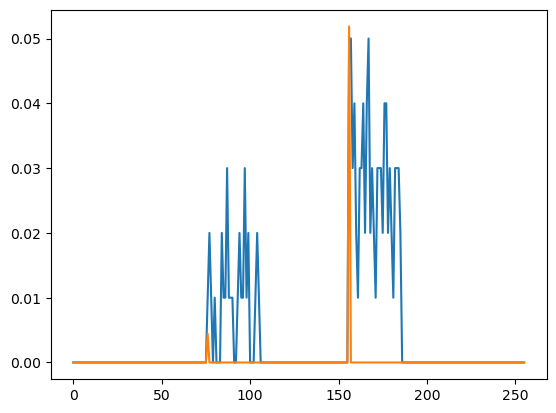

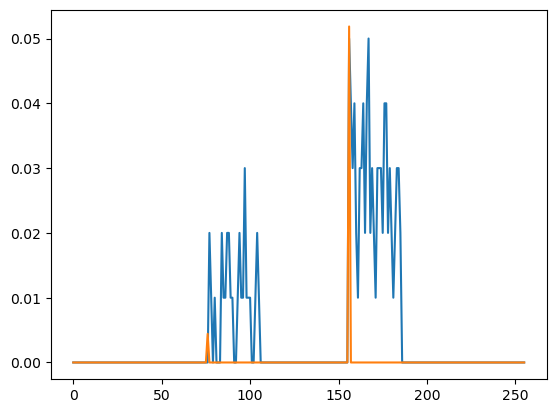

In [16]:
for i in range(len(Is_tr)):
    if not torch.all(fs_tr[i] <= 0.01):
        plt.figure()
        pred_fs = predict(model, Is_tr[i], fs_tr[i], k)
        ts = list(range(len(Is_tr[i])-k-1))
        plt.plot(ts, fs_tr[i][k+1:])
        plt.plot(ts, pred_fs)

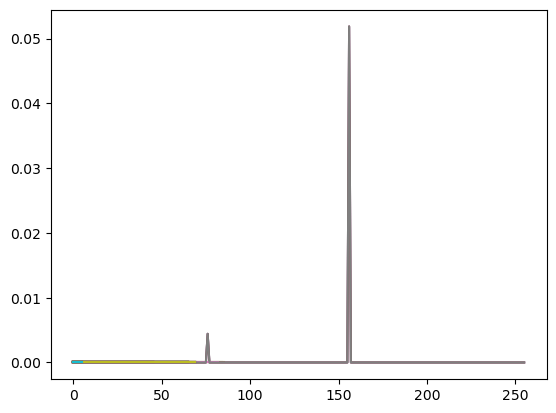

In [17]:
for i in range(len(Is_tr)):
    pred_fs = predict(model, Is_tr[i], fs_tr[i], k)
    ts = list(range(len(Is_tr[i])-k-1))
    #plt.plot(ts, fs_tr[i][k+1:])
    plt.plot(ts, pred_fs)

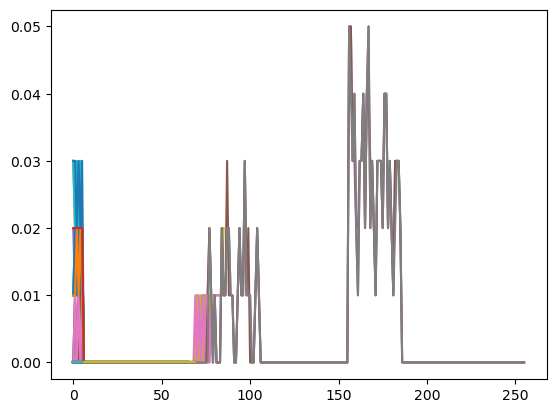

In [18]:
for i in range(len(Is_tr)):
    #plt.figure()
    pred_fs = predict(model, Is_tr[i], fs_tr[i], k)
    ts = list(range(len(Is_tr[i])-k-1))
    plt.plot(ts, fs_tr[i][k+1:])
    #plt.plot(ts, pred_fs)

In [ ]:
data[cell_id]